In [28]:
import numpy as np
import pandas as pd
from pathlib import Path

#specify path where Kilosort output files are located
data_dir = '/Users/dyballa/repos/TempoSort/data/2017_UCL_Neuropixels/60s'
# outputs saved to results_dir
results_dir = Path(data_dir).joinpath('kilosort4')

# load 'em
ops = np.load(results_dir / 'ops.npy', allow_pickle=True).item()
camps = pd.read_csv(results_dir / 'cluster_Amplitude.tsv', sep='\t')['Amplitude'].values
contam_pct = pd.read_csv(results_dir / 'cluster_ContamPct.tsv', sep='\t')['ContamPct'].values
chan_map =  np.load(results_dir / 'channel_map.npy')
templates =  np.load(results_dir / 'templates.npy')
chan_best = (templates**2).sum(axis=1).argmax(axis=-1)
chan_best = chan_map[chan_best]
amplitudes = np.load(results_dir / 'amplitudes.npy')
st = np.load(results_dir / 'spike_times.npy')
clu = np.load(results_dir / 'spike_clusters.npy')
firing_rates = np.unique(clu, return_counts=True)[1] * 30000 / st.max()
dshift = ops['dshift']

In [29]:
# ### exporting data in .mat format for JIM

# assert st.size == clu.size
# res = []
# for si, cli in zip(st, clu):
#     res.append([si, cli, chan_best[cli]])
# res = np.array(res, dtype='int')

# from scipy.io import savemat
# savemat('spike_times_neurons_channels.mat',{'spk_times':res[:,0], 'neuron_id':res[:,1], 'best_chan':res[:,2],})

In [106]:
inputfilename = f'{data_dir}/Hopkins_20160722_g0_t0.imec.ap_CAR.60sec.bin'
nrows = 385
with open(inputfilename, 'rb') as fid:
    data_array = np.fromfile(fid, np.int16).reshape((-1, nrows)).T
data_array.shape


(385, 1800000)

In [56]:
# # Jim's filtering approach
# from scipy.ndimage import convolve
# winSize = 30
# filt = np.ones(winSize)/winSize
# for chan in range(nrows):
#     print('.',end='')
#     LFiltered = convolve(data_array[chan], filt, mode='mirror')
#     HFiltered = data_array[chan] - LFiltered
#     data_array[chan] = HFiltered


.................................................................................................................................................................................................................................................................................................................................................................................................

In [102]:
# Get high-pass filtering procedures from Kilosort 4
#https://github.com/MouseLand/Kilosort/blob/main/kilosort/preprocessing.py

from scipy.signal import butter, filtfilt
def get_highpass_filter(fs=30000, cutoff=300):#, device=torch.device('cuda')):
    """Filter to use for high-pass filtering."""
    NT = 30122
    
    # a butterworth filter is specified in scipy
    b,a = butter(3, cutoff, fs=fs, btype='high')

    # a signal with a single entry is used to compute the impulse response
    x = np.zeros(NT)
    x[NT//2] = 1

    # symmetric filter from scipy
    hp_filter = filtfilt(b, a , x).copy()
    
    #hp_filter = torch.from_numpy(hp_filter).to(device).float()
    return hp_filter

def fft_highpass(hp_filter, NT=30122):
    """Convert filter to fourier domain."""
#     device = hp_filter.device
    ft = hp_filter.shape[0]

    # the filter is padded or cropped depending on the size of NT
    if ft < NT:
        pad = (NT - ft) // 2
        fhp = fft(np.concatenate((np.zeros(pad), 
                             hp_filter,
                             np.zeros(pad + (NT-pad*2-ft)))))
    elif ft > NT:
        crop = (ft - NT) // 2 
        fhp = fft(hp_filter[crop : crop + NT])
    else:
        fhp = fft(hp_filter)
    return fhp

from numpy.fft import fft, ifft, fftshift
sample_rate = 30000


# filter raw data -- do it one channel at a time due to memory constraints
hp_filter = get_highpass_filter(sample_rate)
for i in range(len(chan_map)):
    chan = chan_map[i]
    X = data_array[chan:chan+1]

    # apply filter in Fourier space
    fwav = fft_highpass(hp_filter, NT=X.shape[1])
    X = np.real(ifft(fft(X) * np.conj(fwav)))
    X = fftshift(X, axes = -1)
    
    data_array[chan] = X[0]

In [4]:
# Check the contamination of each template
print(list(enumerate(contam_pct[:20])))

[(0, 94.3), (1, 69.3), (2, 79.4), (3, 95.2), (4, 65.1), (5, 58.1), (6, 7.9), (7, 63.5), (8, 88.6), (9, 66.7), (10, 41.0), (11, 22.5), (12, 100.1), (13, 0.0), (14, 75.6), (15, 46.1), (16, 63.6), (17, 84.8), (18, 0.0), (19, 73.8)]


In [17]:
# how many spks per neuron template ("cluster")
for templi in range(25):
    print(templi, (clu == templi).sum())

0 669
1 387
2 401
3 714
4 260
5 235
6 127
7 227
8 259
9 104
10 183
11 131
12 289
13 50
14 172
15 90
16 87
17 138
18 225
19 331
20 334
21 374
22 317
23 443
24 517


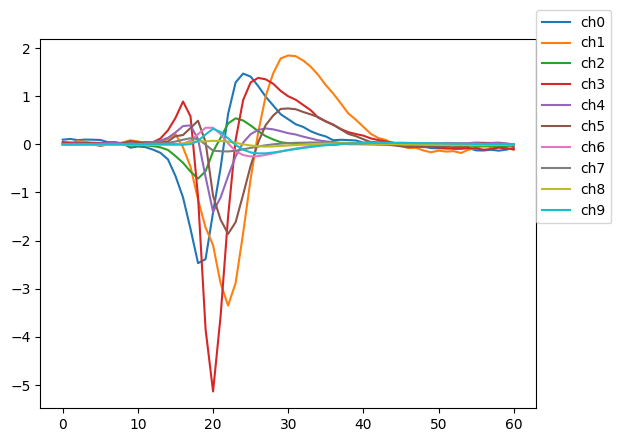

In [107]:
templi = 0 #choose a given template

# these show the waveforms for several channels in a given template (channels not considered are zeroed)
# templates.shape (#template, #time pts, #num good channels)
from pathlib import Path
import matplotlib.pyplot as plt
results_dir = Path(data_dir).joinpath('kilosort4')
templates =  np.load(results_dir / 'templates.npy')

which_chans = []
for i in range(374): #plot the waveform from each channel participating in that template
    if abs(templates[templi,:,i]).sum() > 0:
        which_chans.append(chan_map[i]) #convert the channel index (0--373) to the global index (0--384, the full probe)
        plt.plot(templates[templi,:,i], label=f'ch{i}');
plt.legend(loc=(1,.5))
plt.show()


Showing first 8 spikes from template 0


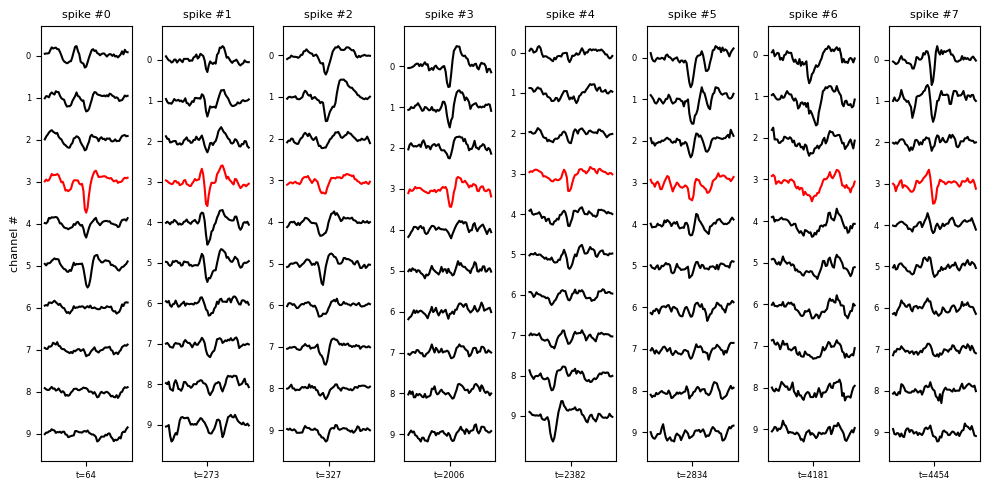

Average spike window from template 0


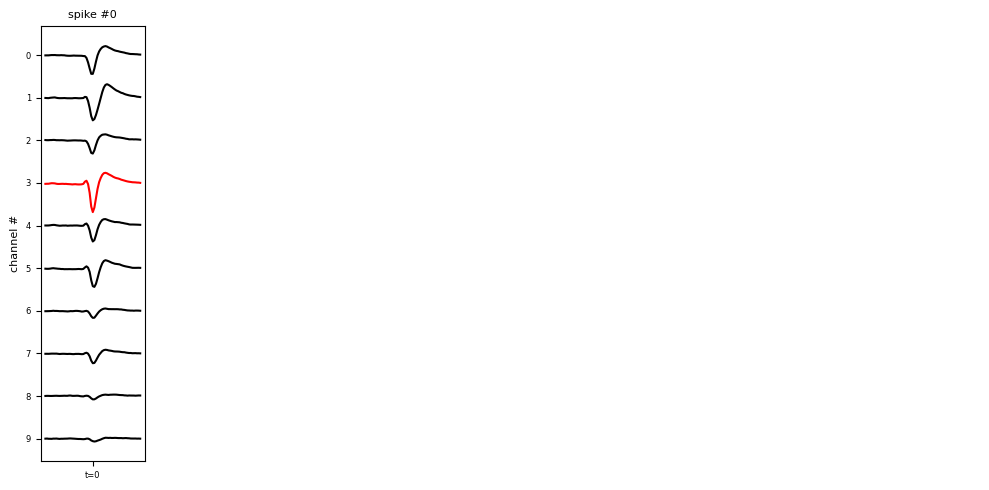

In [108]:
def plot_multichannel_spike(my_spk_windows, which_chans, spk_ts, max_spikes_per_fig, mainChan):
    """plot temporal window around each spike in `my_spk_windows`
    each entry in my_spk_windows is a 2D array of dimensions (# channels)-by-(window size)
    `which_chans` identifies the (global) channel id of each row in `my_spk_windows`
    `mainChan` identifies the (global) id of the main channel in the template, to be plot in red"""
    ncols = max_spikes_per_fig
    half_window = my_spk_windows
    nChannels = len(which_chans)
    assert len(my_spk_windows[0] == nChannels)
    
    for ii in range(len(my_spk_windows)):
        coli = ii % ncols
        if coli  == 0:
            f, axes = plt.subplots(1, ncols, figsize=(1.25 * ncols, .5*nChannels*1))
            if ncols == 1:
                axes = [axes]

        this_spk_windows = my_spk_windows[ii]
        height = np.nanmax(this_spk_windows) - np.nanmin(this_spk_windows)
        
        ax = axes[coli]  
        for chani, chan in enumerate(which_chans):

            ax.plot(this_spk_windows[chani] - chani*height, color='r' if chan == mainChan else 'k')

            ax.set(xticks=[this_spk_windows[chani].size//2], yticks=-np.arange(nChannels)*height)
            ax.set_xticklabels([f't={spk_ts[ii]}'], size=6)
            ax.set_yticklabels(which_chans, size=6)
            ax.set_title(f'spike #{ii}', size=8)
            if coli == 0:
                ax.set_ylabel('channel #', size=8)

        if coli == (ncols - 1):# or spki == (len(which_spikes_to_show) - 1):
            f.tight_layout()
            plt.show()
    # hide any remaining empty subplots
    if coli < (ncols - 1):
        for coli in range(coli+1, ncols):
            axes[coli].axis('off')
        f.tight_layout()
        plt.show()        

max_n_spikes_to_show = 8

which_spikes_from_templ = np.flatnonzero(clu == templi)
print(f'Showing first {max_n_spikes_to_show} spikes from template {templi}')


max_spikes_per_fig = 8 # each spike will be shown as a column

half_window = templates.shape[1]//2
# which_chans = range(1, 18+1)
#crop out a window around the spike times for each channel in this template
# use `st[spki]` to get the actual time (sample #) of each spike
all_spk_windows = []
actual_spike_ts = st[which_spikes_from_templ]
for spki in which_spikes_from_templ:
    t0, t1 = max(0, st[spki]-half_window), min(st[spki]+half_window+1, data_array.shape[1])
    
    if t1 - t0 < 2*half_window+1:
        start, end = 0, 2*half_window+1
        window = np.nan*np.ones((len(which_chans),2*half_window+1))
        if st[spki] < half_window:
            start = half_window-st[spki]
        if st[spki] + half_window + 1 > data_array.shape[1]:
            end -= ( data_array.shape[1] - st[spki] + half_window + 1 )
    
        window[:,start:end] = data_array[which_chans,t0:t1]
    else:
        window = data_array[which_chans,t0:t1]
    all_spk_windows.append(window)

plot_multichannel_spike(all_spk_windows[:max_n_spikes_to_show], which_chans, actual_spike_ts[:max_n_spikes_to_show],
                        max_spikes_per_fig, chan_best[templi])



# Now compute the mean spike window for each channel in this template (across all spikes from this template),
# and compare with the actual template
# mean_spk_windows = [np.mean([data_array[which_chans,st[spki]-half_window:st[spki]+half_window+1] for spki in which_spikes_from_templ], 0)]
mean_spk_windows = [np.nanmean(all_spk_windows, axis=0)]
print(f'Average spike window from template {templi}')

plot_multichannel_spike(mean_spk_windows, which_chans, [0], max_spikes_per_fig, chan_best[templi])



In [11]:
# NOTE: most templates have 10 chans, but a few have 12... why? probably depends on the position along the probe
print([len(np.flatnonzero(abs(templates[templi]).sum(0) > 0)) for templi in range(templates.shape[0])])

[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 12, 10, 10, 10, 10, 10, 10, 10, 12, 10, 10, 12, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 12, 10, 10, 12, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]


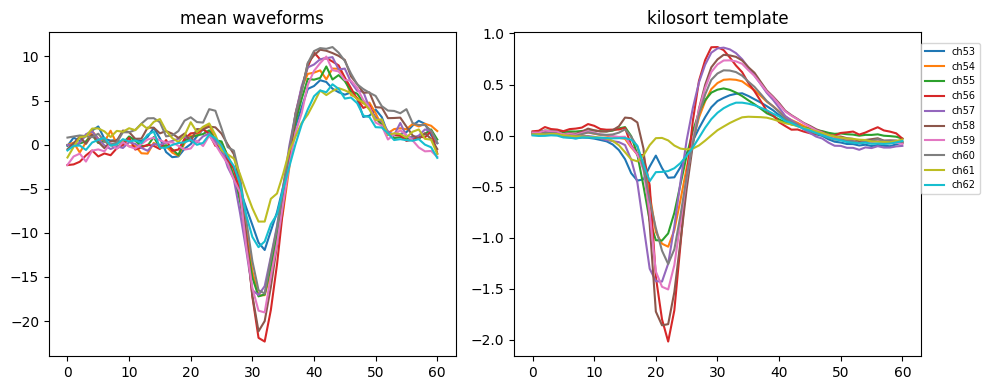

In [12]:
# now plot them all together, and compare with the official template output by kilosort
f, (ax0, ax1) = plt.subplots(1, 2, figsize=(10,4))
ax0.plot(mean_spk_windows[0].T)
ax0.set(title='mean waveforms')

for i in np.flatnonzero(abs(templates[templi]).sum(0) > 0): #plot the waveform from each channel participating in the chosen template
    ax1.plot(templates[templi,:,i], label=f'ch{i}');
ax1.legend(loc=(1,.5), fontsize=7)
ax1.set(title='kilosort template')
f.tight_layout()
plt.show()

In [ ]:
#TODO -- save which channel each spike in 'spike_times.npy' came from
# understand how spikes are detected
# understand how channels are combined to form a multi-channel template

# idea: cluster spike waveforms around detected spikes (separately for each channel?); 
    # use their centroids for template matching
    # then check which templates appear consistently nearby in time (or even in the same temporal sequence)
    # could do that by simply taking see which template "traces" (result of filtering oriignal trace with template) are highly
     # similar (dot product?) -- but might need to shift in time to allow decent overlap... convNMF might be ideal for that
    # use similarity matrix to cluster templates into multi-channel templates, which are electrical signatures of putative neurons!
        
# online approach:
 # as soon as a spike is detected, compare with current spike and see it fits in an existing cluster (Winner-Take-All), o.w. start
    # a new one.
 # as new trace samples come in, always filter them with the current clusters(templates), and update running dot-prod similarity

# with updated similarities, update the cluster assignments. ideally, a hierarchical dendrogram where the user can judge
# what are the best cuts

In [60]:
# these show the waveforms for several channels in each template (channels not considered are zeroed)
# templates.shape (#template, #time pts, #num good channels)

templi = 3
tot = 0
for i in range(374):
    
    if templates[templi,:,i].sum() > 0:
        plt.plot(templates[templi,:,i]);
        tot += 1
print(tot)

0


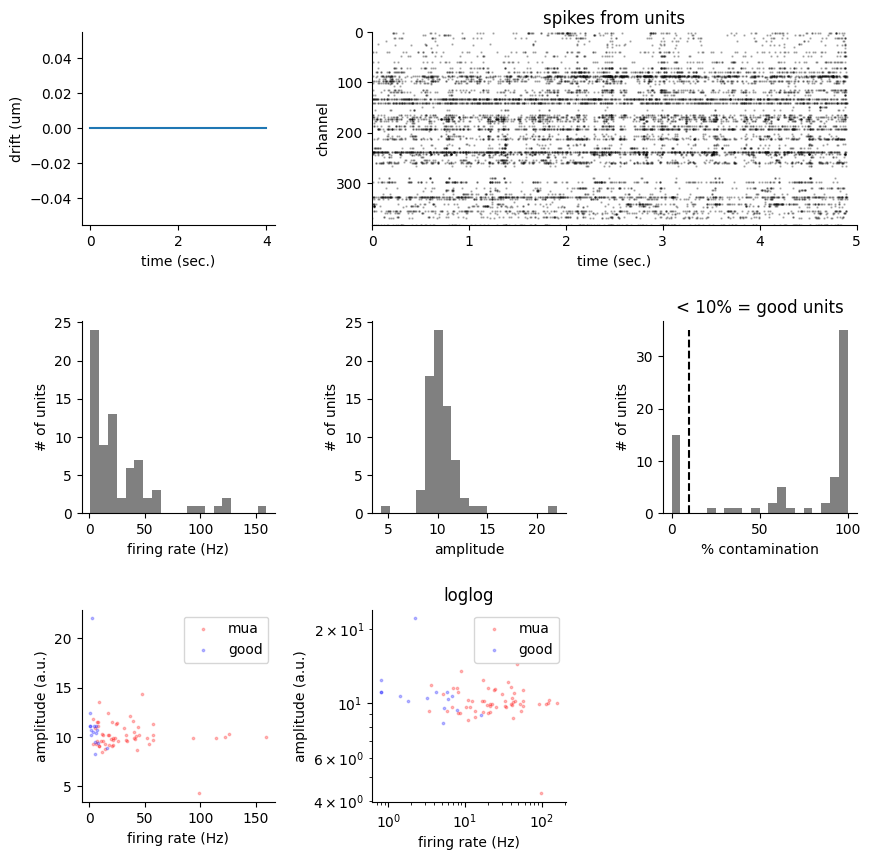

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import gridspec, rcParams
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
gray = .5 * np.ones(3)

fig = plt.figure(figsize=(10,10), dpi=100)
grid = gridspec.GridSpec(3, 3, figure=fig, hspace=0.5, wspace=0.5)

ax = fig.add_subplot(grid[0,0])
ax.plot(np.arange(0, ops['Nbatches'])*2, dshift);
ax.set_xlabel('time (sec.)')
ax.set_ylabel('drift (um)')

ax = fig.add_subplot(grid[0,1:])
t0 = 0
t1 = np.nonzero(st > ops['fs']*4.9)[0][0]
ax.scatter(st[t0:t1]/30000., chan_best[clu[t0:t1]], s=0.5, color='k', alpha=0.25)
ax.set_xlim([0, 5])
ax.set_ylim([chan_map.max(), 0])
ax.set_xlabel('time (sec.)')
ax.set_ylabel('channel')
ax.set_title('spikes from units')

ax = fig.add_subplot(grid[1,0])
nb=ax.hist(firing_rates, 20, color=gray)
ax.set_xlabel('firing rate (Hz)')
ax.set_ylabel('# of units')

ax = fig.add_subplot(grid[1,1])
nb=ax.hist(camps, 20, color=gray)
ax.set_xlabel('amplitude')
ax.set_ylabel('# of units')

ax = fig.add_subplot(grid[1,2])
nb=ax.hist(np.minimum(100, contam_pct), np.arange(0,105,5), color=gray)
ax.plot([10, 10], [0, nb[0].max()], 'k--')
ax.set_xlabel('% contamination')
ax.set_ylabel('# of units')
ax.set_title('< 10% = good units')

for k in range(2):
    ax = fig.add_subplot(grid[2,k])
    is_ref = contam_pct<10.
    ax.scatter(firing_rates[~is_ref], camps[~is_ref], s=3, color='r', label='mua', alpha=0.25)
    ax.scatter(firing_rates[is_ref], camps[is_ref], s=3, color='b', label='good', alpha=0.25)
    ax.set_ylabel('amplitude (a.u.)')
    ax.set_xlabel('firing rate (Hz)')
    ax.legend()
    if k==1:
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_title('loglog')